# MNIST dataset

The Notebook is split in three parts:
* Data Preparation
* Model Building
* Evaluation

## Data Preparation

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gwehrm\AppData\Roaming\P

In [2]:
# load the data
train = pd.read_csv("./Data/train.csv")
test  = pd.read_csv("./Data/test.csv")

In [3]:
display(train.shape)
display(test.shape)
# 42000 different training observations with 784 pixel values and label in the first column
# the pixel valies need to be rearranged to 28*28

(42000, 785)

(28000, 784)

In [4]:
# label
y_train = train["label"]

# predictors
x_train = train.drop(columns = 'label')
x_test = test
# del old df
del train

In training the NN, scaling data is important. The pixel intensities of images are in the range of [0, 255], which makes the neural network difficult to learn.

In [5]:
x_train = x_train/255
x_test = x_test/255

In [6]:
x_train = x_train.values.reshape(42000,28,28,1)
x_test = test.values.reshape(28000,28,28,1)
display(x_train.shape)

(42000, 28, 28, 1)

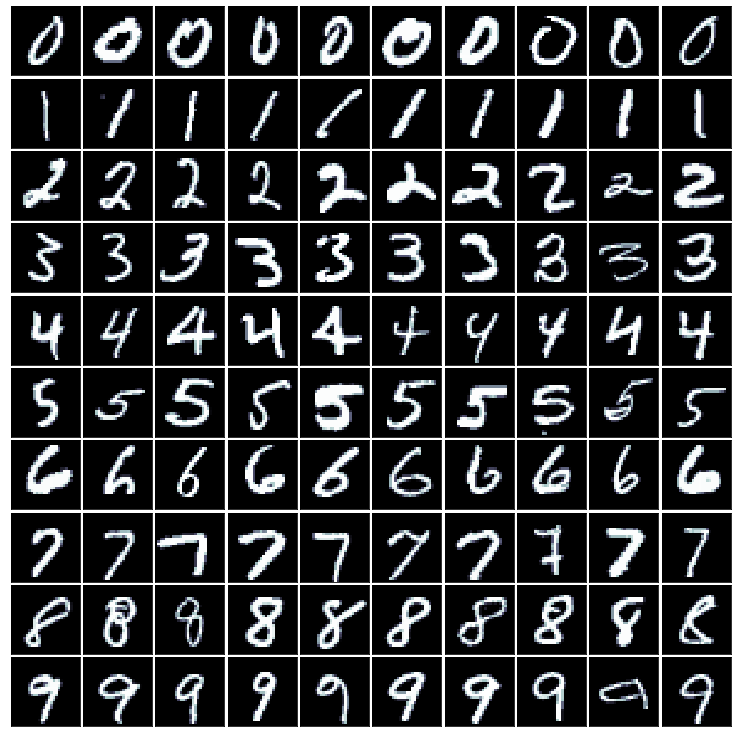

In [7]:
# show some random digits for each label

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)           
        
        
# get unique labels
unique_labels = np.unique(y_train)

# get the index/label for them
images = []
for l in unique_labels:    
    idx = np.where(y_train == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]] 
    for i in idx:
        images += [x_train[i].reshape(28,28)]

display_images(images,shape=(10, 10))

In [8]:
# the labels are integers - therefore, the keras function to_categorical can be used to encode it
from keras.utils import to_categorical

# transformation:
def ohe(labs):
    ohe_labs = to_categorical(labs)
    return ohe_labs
y_train = ohe(y_train)

In [9]:
# prepare for splitting 0.3 - split the train data in another train and validation set
ss = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=1)

#split and get train/val
ss.get_n_splits(x_train, y_train)
for train_index, val_index in ss.split(x_train, y_train):
    x_train, x_val = x_train[train_index], x_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    print(len(y_train),len(y_val))

29400 12600


## Model Building

In [10]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(10, kernel_size=3, activation='relu', 
               input_shape=(28,28,1),
                padding = "same"))

model.add(Dropout(0.1))

model.add(Conv2D(10, kernel_size=6, activation='relu'))

model.add(Dropout(0.1))

model.add(Conv2D(10, kernel_size=9, activation='relu'))

# model.add(Conv2D(10, kernel_size=12, activation='relu'))


# Flatten the output of the convolutional layer
model.add(Flatten())
# Add an output layer for the categories
model.add(Dense(10, activation='softmax'))

In [11]:
# Compile the model 
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Fit the model on a training set
model.fit(x_train, y_train, 
          validation_split=0.2, 
          epochs=20, batch_size=1000)

W1218 13:58:48.079140 15224 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 23520 samples, validate on 5880 samples
Epoch 1/20
23520/23520 [==============================] - 40s 2ms/step - loss: 1.2304 - accuracy: 0.6493 - val_loss: 0.4965 - val_accuracy: 0.8575
Epoch 2/20
23520/23520 [==============================] - 42s 2ms/step - loss: 0.3934 - accuracy: 0.8889 - val_loss: 0.2823 - val_accuracy: 0.9170
Epoch 3/20
23520/23520 [==============================] - 49s 2ms/step - loss: 0.2535 - accuracy: 0.9242 - val_loss: 0.2081 - val_accuracy: 0.9359
Epoch 4/20
23520/23520 [==============================] - 40s 2ms/step - loss: 0.1889 - accuracy: 0.9449 - val_loss: 0.1528 - val_accuracy: 0.9524
Epoch 5/20
23520/23520 [==============================] - 37s 2ms/step - loss: 0.1465 - accuracy: 0.9565 - val_loss: 0.1326 - val_accuracy: 0.9577
Epoch 6/20
23520/23520 [==============================] - 37s 2ms/step - loss: 0.1257 - accuracy: 0.9634 - val_loss: 0.1099 - val_accuracy: 0.9663
Epoch 7/20
23520/23520 [==============================] - 37s 2ms/ste

In [12]:
# evaluate the model:
model.evaluate(x_val,y_val)

12600/12600 [==============================] - 4s 326us/step


[0.05969117213506252, 0.9832539558410645]

In [13]:
# I reached an accuracy of 98.22% 

## Data Augmentation:

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=1000),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10
919/918 [==============================] - 1553s 2s/step - loss: 0.1135 - accuracy: 0.9654
Epoch 2/10
919/918 [==============================] - 1496s 2s/step - loss: 0.0643 - accuracy: 0.9798
Epoch 3/10
215/918 [======>.......................] - ETA: 19:24 - loss: 0.0555 - accuracy: 0.9826